## NLP: Product Reviews Summary

### Part 1: Data Analysis
The task at hand is to design a system that can take a set of customer reviews of a product and give a summary of the main features and their associated positive and negative sentiments. This will give a buyer useful granulated information when buying a product, compared to the usual five-star rating, as they can focus on the features that they are looking for in a product. Below is what the output will look like.

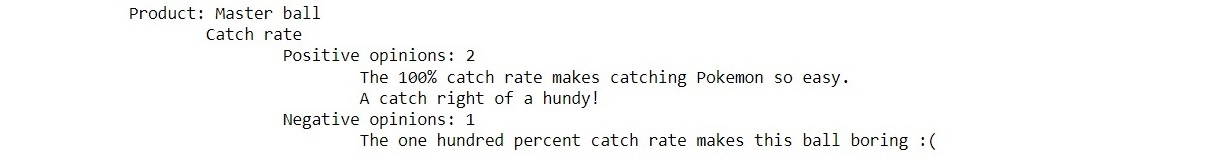

There are 17 files of reviews and review sentences across three data sets from the University of Chicago database. These were taken from Amazon and annotated by Bing Liu for his work in aspect extraction (Hu and Liu., 2004). Two of these have detailed annotations including comparison sentence, [cc] and pronoun resolution [p]. The third dataset has simple tags consisting of just the feature and a sentiment tag up from -3 to +3 (excluding 0) like the other two do. There are some other differences between the datasets, such as the lower-case function and, as shown below. The review titles in the 5-product review set do contain features and sentiments, but these are not labelled, so I will not include them as part of the data I ingest.


| Dataset | Sentences | Lowercase  | Tokenized  | Split by review [t] |
| :- | :-: | :-: | :-: | :-: |
| Reviews-9-products | 4,250 | No | No | Yes |
| Customer_review_data_5_pr | 3,944 | Yes | Yes | Yes |
| CustomerReviews-3_domains | 2,099 | No | Yes | No |


I will use four of the product files containing 2,057 sentences out of the 10,293 total, approximately 20% as my test set. The remaining 13 product files will be used in various ways as training data.
Firstly, the data will be ingested, and put into a list of [“sentence”, “sentiment tag”, [features]] format lists for each file. Then, various pre-processing steps will be done on each sentence. These new sentences will be saved into a dictionary, with the original sentence as the key for easy access.

Each feature in the reviews has an individual sentiment tag. For sentiment analysis, I am going to assign each sentence either a positive or negative sentiment. Breaking down the sentence into individual parts for each feature is not a realistic process, as they are often intertwined, and using incomplete sentences in the summary would not give the buyer a good user experience. For this reason, I am going to sum the tags and then assign a positive, neutral, or negative tag. The neutral tag is not ideal, as these will not be used in training of the sentiment classifier, but as shown below they make up less than 1% of the sentences.

In [22]:
import operator
from collections import Counter
import contractions
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from efficient_apriori import apriori
from itertools import permutations
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
import random
#!pip install efficient-apriori
#!pip install contractions

In [2]:
def sent_processor(line):
    # A line with attributes. We want to capture the features and if they were positive or negative.
    sentence = "Error"
    sentiment = "Error Sent"
    features = []
    # features in raw string form e.g. infrared[-2] or [cc] (as extra tags are saved small to be stripped out).
    raw_features = []
    # Variable to store the features in form ("feature", 2) before they are processed to assign sentiment.
    pre_features = []
    # sentiment score starts at 0.
    sentiment_score = 0
    data = []
    current_feature = ""

    def process_feature(to_process):
        """Function to take infrared[-2] and return (infared, -2)"""
        if to_process[0] == " ":
            # removes a space in front of a feature tag.
            to_process = to_process[1:]
        if to_process[-3:] == "[+]":
            # If feature is missing a number with sentiment, make sentiment +2 (between 1 and 3).
            to_process = to_process[0:-3] + "[+2]"
        if to_process[-3:] == "[-]":
            # If feature is missing a number with sentiment, make sentiment -2 (between 1 and 3).
            to_process = to_process[0:-3] + "[-2]"

        # Return the feature and either a positive or negative number for the sentiment.
        if to_process[-3] == "+":
            return to_process[:-4].strip(), int(to_process[-2])
        if to_process[-3] == "-":
            return to_process[:-4].strip(), -1 * int(to_process[-2])
        else:
            return False

    for index, char in enumerate(line):
        if char == ",":
            pass
        else:
            if char != "]":
                current_feature += char
            else:
                # Add current feature in tuple form ("feature", "Pos) to features and reset feature.
                current_feature += char
                raw_features.append(current_feature)
                current_feature = ""
        if char == "#":
            # End of tags, so tags and the sentence can be added to data.
            sentence = line[index + 2:]
            for feature in raw_features:
                # Add features longer than four characters (strips out [v] and [cc])
                if len(feature) < 5:
                    pass
                else:
                    pre_features.append(process_feature(feature))
            break
    # Process features and update sentiment score for each feature.
    for feat in pre_features:
        if feat:
            # Check that all features are legitimate
            features.append(feat[0])
            sentiment_score += feat[1]
    # Assign sentiment based on sentiment_score
    if sentiment_score > 0:
        sentiment = "Pos"
    elif sentiment_score < 0:
        sentiment = "Neg"
    else:
        sentiment = "Neutral"

    # Obtain Lemma of features and make lowercase, including two word features e.g. "Diaper Bags" -> "diaper bag".
    wn = WordNetLemmatizer()
    features = ["".join([wn.lemmatize(i) + " " for i in this_string.lower().split()]).strip() for this_string in features]

    return [sentence, sentiment, features]

In [3]:
"""Demonstration of the sentence processing function"""
tests = ["Pokedex[+3][p][cc]##It's far better than all others on the market.",
         "Pokeballs[2], rucksack[-2][u]##I find the my rucksack is too are heavy and my many Pokeballs are useful",
         " colour [+][U], radio[-],infrared[-3][cc]##my favorite features are the radio and the infrared and it is red. "]


def testing(tests):
    for sent in tests:
        print(sent)
        print(sent_processor(sent))
        print()


testing(tests)

Pokedex[+3][p][cc]##It's far better than all others on the market.
["It's far better than all others on the market.", 'Pos', ['pokedex']]

Pokeballs[2], rucksack[-2][u]##I find the my rucksack is too are heavy and my many Pokeballs are useful
['I find the my rucksack is too are heavy and my many Pokeballs are useful', 'Neg', ['rucksack']]

 colour [+][U], radio[-],infrared[-3][cc]##my favorite features are the radio and the infrared and it is red. 
['my favorite features are the radio and the infrared and it is red. ', 'Neg', ['colour', 'radio', 'infrared']]



In [4]:
verbose = False

# Manually added expanded contractions for the sentences that have already been tokenized.
contractions.add("can't", 'can not')
contractions.add("cannot", 'can not')
contractions.add("n't", 'not')
contractions.add("'re", "are")
contractions.add("'t", "not")
contractions.add("'s", "is")
contractions.add("'d", "would")
contractions.add("'ll", "will")
contractions.add("'ve", "have")
contractions.add("'m", "am")
contractions.add("ringtones", "ringtone")  # Addition as WordNet does not have ringtone as lemma of ringtones

In [5]:
def process_file(file_to_process, stats=False):
    """Function to ingest a file, process each line and give a lsit of the processed sentences as an output.
    It will also print/return statistics about the file if stats is set to True."""
    line_count = 0
    pos_sents = 0
    neg_sents = 0
    neutral_sents = 0
    no_sentiment_sents = 0
    data = []
    stats_features = []
    with open(file_to_process) as file:
        for line in file:
            header_line = False
            line = line.strip()
            try:
                if line[0] == "*":
                    # This is a head description line, so pass
                    header_line = True
            except IndexError:
                pass
            if line == "":
                pass
            elif header_line:
                # If it is a header description  line we do not want to process it.
                pass
            elif "[t]" in line:
                # This is the title of the review, or signifies the start of a new one, so not processed.
                pass
            elif"##" in line:
                # If it has ## in it then it is a sentence line to be processed.
                if line[0:2] == "##":
                    # If starts with ## it is a sentence with no features or sentiment value.
                    # print(f"appending: {[line[2:], 'None', []]}")
                    data.append([line[2:], 'None', []])
                    line_count += 1
                    no_sentiment_sents += 1
                else:
                    data.append(sent_processor(line))
                    if stats:
                        for feat in sent_processor(line)[2]:
                            stats_features.append(feat)
                        line_count += 1
                        # Update the sentiment counter appropriately
                        if sent_processor(line)[1] == "Pos":
                            pos_sents += 1
                        if sent_processor(line)[1] == "Neg":
                            neg_sents += 1
                        if sent_processor(line)[1] == "Neutral":
                            neutral_sents += 1
    if stats:
        feature_counts = Counter(stats_features)
        sorted_counts = sorted(feature_counts.items(), key=operator.itemgetter(1), reverse=True)
        # Print Stats about file
        print(f"File is:{file_to_process}")
        print(f"Line count: {line_count}")
        print(f"Positive Sentences: {pos_sents}, which is {(pos_sents/line_count)*100:.1f}%.")
        print(f"Negative Sentences: {neg_sents}, which is {(neg_sents/line_count)*100:.1f}%.")
        print(f"Neutral Sentences: {neutral_sents}, which is {(neutral_sents/line_count)*100:.1f}%.")
        print(f"No features Sents: {no_sentiment_sents}, which is {(no_sentiment_sents/line_count)*100:.1f}%.")
        print("Feature Statistics:")
        print(f"Total number of features: {len(stats_features)}")
        print(f"Number of unique features: {len(set(stats_features))}")
        print(f"Mean average features per sentence: {len(stats_features)/line_count:.1f}")
        print()
        print("Top ten features sorted by frequency:")
        print(sorted_counts[:25])
        top_ten_total = sum(c[1] for c in sorted_counts[:10])
        print(f"Top ten is {top_ten_total} features, which is {top_ten_total/len(stats_features)*100:.1f}% of the total features.")
        top_twentyfive_total = sum(c[1] for c in sorted_counts[:25])
        print(f"Top twenty-five is {top_twentyfive_total} features, which is {top_twentyfive_total/len(stats_features)*100:.1f}% of the total features.")
        top_fifty_total = sum(c[1] for c in sorted_counts[:50])
        print(f"Top fifty is {top_fifty_total} features, which is {top_fifty_total/len(stats_features)*100:.1f}% of the total features.")
        print()

    return data

In [6]:
# All files - As all files will be pre-processed
folder_1 = "Data/Customer_review_data/"
files_1 = ["Apex AD2600 Progressive-scan DVD player.txt", "Canon G3.txt", "Creative Labs Nomad Jukebox Zen Xtra 40GB.txt", "Nikon coolpix 4300.txt", "Nokia 6610.txt"]
folder_2 = "Data/CustomerReviews-3_domains/"
files_2 = ["Computer.txt", "Router.txt", "Speaker.txt"]
folder_3 = "Data/Reviews-9-products/"
files_3 = ["Canon PowerShot SD500.txt", "Canon S100.txt", "Diaper Champ.txt", "Hitachi router.txt", "ipod.txt", "Linksys Router.txt", "MicroMP3.txt", "Nokia 6600.txt", "norton.txt"]

Below are the statistics drawn from each file, showing the proportion of the sentences that are each sentiment (or have none), the total number of features, the number of unique features, and the proportion of the total features that the top 10, 25, and 50 features make up.

From this we can see that around half the sentences have annotations and that although most products have from 80-200 features, the top 50 make up over 70% of those features most of the time. This shows that the there is a commonly a long tail of very infrequent features after the main ones have been listed.

A multistage feature extraction will then be done. Each sentence that includes a feature will then be classified as positive or negative. The results of this will then be combined to give the final product review summarisation.

In [7]:
def run_all_stats():
    """"""
    for file in files_1:
        file = folder_1 + file
        process_file(file, True)
    for file in files_2:
        file = folder_2 + file
        process_file(file, True)
    for file in files_3:
        file = folder_3 + file
        process_file(file, True)


run_all_stats()

File is:Data/Customer_review_data/Apex AD2600 Progressive-scan DVD player.txt
Line count: 739
Positive Sentences: 149, which is 20.2%.
Negative Sentences: 193, which is 26.1%.
Neutral Sentences: 2, which is 0.3%.
No features Sents: 395, which is 53.5%.
Feature Statistics:
Total number of features: 428
Number of unique features: 115
Mean average features per sentence: 0.6

Top ten features sorted by frequency:
[('player', 100), ('dvd', 29), ('play', 24), ('customer service', 17), ('picture', 13), ('dvd player', 12), ('remote', 12), ('look', 11), ('apex', 10), ('read', 10), ('format', 10), ('feature', 9), ('no disc', 9), ('sound', 7), ('price', 7), ('dvd-r', 4), ('support', 4), ('door', 4), ('disc', 4), ('size', 4), ('cd', 3), ('quality', 3), ('jpeg', 3), ('unit', 3), ('design', 3)]
Top ten is 238 features, which is 55.6% of the total features.
Top twenty-five is 315 features, which is 73.6% of the total features.
Top fifty is 363 features, which is 84.8% of the total features.

File is:

File is:Data/Reviews-9-products/Diaper Champ.txt
Line count: 375
Positive Sentences: 157, which is 41.9%.
Negative Sentences: 55, which is 14.7%.
Neutral Sentences: 0, which is 0.0%.
No features Sents: 163, which is 43.5%.
Feature Statistics:
Total number of features: 239
Number of unique features: 71
Mean average features per sentence: 0.6

Top ten features sorted by frequency:
[('diaper champ', 28), ('odor', 19), ('champ', 14), ('product', 13), ('use', 13), ('diaper pail', 13), ('refill', 12), ('work', 11), ('diaper', 11), ('smell', 7), ('pail', 5), ('bag', 4), ('garbage bag', 4), ('trash bag', 4), ('open', 4), ('diaper genie', 3), ('size', 3), ('item', 3), ('hold', 3), ('clean', 3), ('change', 3), ('diaper wipe', 2), ('fit', 2), ('empty', 2), ('opening', 2)]
Top ten is 141 features, which is 59.0% of the total features.
Top twenty-five is 188 features, which is 78.7% of the total features.
Top fifty is 218 features, which is 91.2% of the total features.

File is:Data/Reviews-9-produ

### Part 2: Data pre-processing
The data sets have already been pre-processed, but in different ways, which needs to be considered. The sentences will be tokenized to break them down into lexemes. This is the process of demarcating the string into a list of tokens (Webster and Kit., 1992). This will mostly involve splitting by whitespace for the English language, but clitics will also be split out, as they represent words (Crystal 1980).

Two datasets have already been tokenized, which means the enclitics such as ‘m and n’t have been split from their host words. These need to be corrected to their true word forms. Manual rules will be put in place to make these corrections (“n’t” to “not”).

Part of speech tagging will then be applied. This is the process whereby each word in a sentence is assigned a PoS tag (Jurafsky and Martin., 2020). This is done with trained models that use the previous words tags, as well as the words themselves to generate the most probable tag for the current word. The Penn Treebank tag set (Marcus et al., 1993) is used by the NLTK package (Bird et al., 2009). The NLTK PoS tagger uses an averaged perceptron tagger trained on the Wall Street Journal corpus (Paul and Baker., 1992).

Each token will be lemmatized. This is the process by which each word is reduced to its root or lemma by removing inflectional endings. This also has to be done as two of the datasets have had the annotations lemmatised, e.g. “headphone[-3]##you 're going to need to buy new headphones.” The annotated features will be lemmatised, to ensure that the extracted features match the annotated ones which represent the ground truth. In some cases, such as the example sentence above, will make the summary less readable for the user, as the features will not be in their usual form. For a production model this would either not be applied and processes such as fuzzy matching between lexically similar words (Kalyanathaya et al., 2019) would be used to merge features like headphone (“this came with a broken headphone”) and headphones, with the main word used in the summary.

Any tokens that are or contain punctuation or numbers will then be stripped out. This removes the standard punctuation tokens such as full stops and commas. But will also remove website addresses, which are present in the datasets. The hyphen will be left in, as this can be used in valid words such as “pre-processing”, and is present in some of the feature tags, such as “t-mobile”.

Lastly, stop words will be stripped out. The are words such as “the” and “is” that are insignificant on their own, and link words in the sentence together (Ullman 2011). NLTK has a predefined stop word list of 179 words that I will use.

In [8]:
def pre_processing():
    """Function to pre-process all the sentences by making them lower case, expanding contractions, autocorrecting
    spelling errors and the applying part of speech tagging."""
    # Variable to store all 10,293 sentences before they are preprocessed.
    all_data = []
    processed = 0

    def add_all(data):
        """Function to add the sentence part of each (sentence, sentiment, features) tuple to the sentence list."""
        for sent in data:
            all_data.append(sent[0])

    # Load all the sentences from every data file to be pre-processed.
    for file in files_1:
        file = folder_1 + file
        add_all(process_file(file))
    for file in files_2:
        file = folder_2 + file
        add_all(process_file(file))
    for file in files_3:
        file = folder_3 + file
        add_all(process_file(file))

    # Dictionary of preprocessed files, with the original sentence as the key.
    pre_pro_dic = {}

    # Initiate the Lemmatizer
    word_net_lemmatizer = WordNetLemmatizer()

    for sentence in all_data:
        # Apply pre-processing steps.
        # Expand the contractions and make all the letters lowercase.
        contractions_expanded = contractions.fix(sentence.lower())

        # Using NLTK apply part of speech tagging.
        pos_tagged = pos_tag(word_tokenize(contractions_expanded))

        # Stop word list, with "not" and "no" removed for negation purposes and add custom words.
        stop_list = list((stopwords.words('english')))
        stop_list.remove("not")
        stop_list.remove("no")
        stop_list = stop_list + ["wo", "ca"]

        # String of punctuation, as features that are or included punctuation are to be removed (except the hyphen ("-").
        punctuation_numeric = "!£$%^&*()_=+{}[]:;@'#~<>,.?/\`¬|0123456789"
        processed_sentence = []

        for token in pos_tagged:
            if token[0] in stop_list:
                # Do not process if the word is in the stop list.
                pass
            elif any(i in token[0] for i in punctuation_numeric):
                # Do not process if there is any unwanted punctuation present.
                pass
            else:
                # Obtain the lemma of the token and add it to the list of valid tokens.
                processed_sentence.append((word_net_lemmatizer.lemmatize(token[0]), token[1]))

        # Add to the dictionary, with original sentence as the key."""
        pre_pro_dic[sentence] = processed_sentence
        processed += 1

        if processed % 100 == 0:
            print(f"{processed}, ", end="")

    print(f"Sentences processed: {len(all_data)}.")
    return pre_pro_dic


# Dictionary of all sentences as keys, and the pre_processed sentences as the values.
pre_pro_dic = pre_processing()

100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, Sentences processed: 10293.


In [9]:
"""Demonstration of pre-processing a sentence"""
print("Demonstration of pre-processing a sentence.")
nokia_file = process_file(folder_1 + files_1[4])
print(nokia_file[5])
print(pre_pro_dic[nokia_file[55][0]])

Demonstration of pre-processing a sentence.
['i have owned motorola , panasonic and nokia phones over the last 8 years and generally prefer nokia , this phone combines many of the best nokia features , the only feature missing for me is the voice recognition .', 'None', []]
[('staying', 'VBG'), ('sprint', 'NN'), ('though', 'IN'), ('fear', 'VBP'), ('csr', 'NN'), ('not', 'RB'), ('nearly', 'RB'), ('good', 'JJ'), ('t-mobile', 'NN'), ('clarity', 'NN'), ('reception', 'NN'), ('exceptional', 'JJ')]


### Part 3: Feature extraction:
The Apriori algorithm (Agarwal and Srikant., 1994) will be the starting point for my feature extraction process. This algorithm finds items in a database of sets of items that frequently occur together (above a specified threshold.). It does this by repeated iterations over the database, finding first individual frequently occurring items, and then pairs of these items, and so on. The output is a list of the features that frequently occur together. The “items” in the sets are the nouns in the sentences. This means that the features that are nouns, and noun phrases will be found. After testing various support levels, I find 1% to be the most effective, so the feature, or set of features must appear in at least 1% of the sentences of that product file.

After the Apriori algorithm is done, we are left with sets of tokens e.g. {A, B, C}. The algorithm does not consider the order or how close together they are. For this reason, each permutation of the set is checked. If the words appear in that precise order in at least two sentences in the product file, then the feature is kept. If not, it is pruned. This compactness pruning is like that of Minqing and Hu. (2004). Rather than giving a maximum gap of three as they did, I require an exact match, as the maximum gap could allow two features commonly mentioned together to be accidentally merged.

As the Apriori algorithm gives all the subsets of a set as features (for instance life and battery will both be features if “battery life” is, these redundant features need to be pruned, unless they occur independently of the superset. This is done with pure support pruning (Hu and Liu 2004). The p-support of a feature is the number of times that the feature appears in a sentence that do not include the superset feature that includes the feature. After trying p-supports of 2, 3 and 4, I found 3 to be the most effective in terms of F1 improvement. As with compactness pruning there is a trade-off. With a higher p-support, we are more certain of a feature, which increases precision, but low frequency features may be cut, which lowers recall.

Now the main features have been extracted and pruned, we turn to the infrequent features. For this I used a 6,700-word adjective list. This is an opinion lexicon built by Hu and Liu from their years of research in the field. I will search through the sentences for nouns, that have not already been pruned in previous stages. If there is an adjective in the adjective list adjacent to it, then this feature will be added to the list of infrequent features. This covers the two common uses of adjectives next to a subject. For example, “this is a great car” or “the car is great” (“is” is a stop word, so would have been removed).

This is like the semantic based refinement done by Chinh-Ping (2009) where the extracted features were checked by ensuring that a percentage of the occurrences of that feature were near to an adjective, using a fixed adjective seed list. I did not do this on the main set of extracted features, as it is too specific a requirement. A better way would be to use set of syntactic rules as Qie et al. (2011) did to ensure that the statistically extracted features are syntactically relevant and linked to opinions and not just high frequency nouns/noun phrases.

I implemented a basic “excluded list” to exclude commonly occurring nouns that would never be features, such as “I” and temporal nouns such as “day”, “month” and “year”. An extended exclusion list was added to this as part of the final stage of the feature extraction training. All the infrequent features that were found to not be annotated features were listed, and I then manually went through the list, removing words that looked like they could be plausible aspects for a product. Using this extended list across the thirteen training products results in lower recall, as some annotated features were then excluded when, but the raised precision more than accounted for this, giving a total gain of 2.5% to the average F1 score across the products. For a review summary, readers will mostly be interested in the top features, so excluding some infrequent features should not take away from the overall experience.

Below is a table of the results of the feature extraction. I used distinct precision (correctly extracted features[TP] / all extracted features[TP+FP]) and recall (correctly extracted features[TP]/all annotated features[TP+FN]). Using the proposed method of a weighted precision and recall (Liu 2015), so a higher frequency feature is given more weight, improves the F1 score across all products, showing that most of the main features are being identified, and the infrequent ones are more likely to be missed.

In [10]:
def feature_extract_metrics(actual_features, found_features, sentence_features, found_sentence_features):
    """A function that takes in two sets, the set of actual features for a product, and the features that were extacted.
    It also takes two lists (which must be the same length). These are lists of features for each sentence
    for the product. These are used to compute and return precision, recall and F1 statistics."""
    # True positives is the number of features in the actual feature set that are in the found features set.
    true_positives = len(actual_features.intersection(found_features))
    # Feature Precision: The proportion of identified features that were correctly identified.
    raw_precision = true_positives / len(found_features) * 100
    raw_precision1 = float(f"{raw_precision:.2f}")
    # Feature Recall: The proportion of features that were identified correctly.
    raw_recall = true_positives / len(actual_features) * 100
    raw_recall1 = float(f"{raw_recall:.2f}")
    # F1 Score - The harmonic mean of precision and recall
    f1_score = 2 * ((raw_precision * raw_recall)/(raw_precision + raw_recall))
    f1_score = float(f"{f1_score:.2f}")

    # Create dictionaries of the feature counts annotated features, using the features from each sentence.
    actual_feature_counts = {}
    for sent_feats in sentence_features:
        if sent_feats:
            for aspect in sent_feats:
                # If the feature is in the dictionary already, add one, else add it with a value of one.
                if aspect in actual_feature_counts.keys():
                    actual_feature_counts[aspect] += 1
                else:
                    actual_feature_counts[aspect] = 1

    # The sum or total number of features that were annotated. This is True postives + True negatives (unextracted features)
    sum_of_counts = sum(actual_feature_counts.values())
    # For each extracted featured, get the total number of that number of annotated features, this is our true positives.
    true_positives = 0
    # False positives get incremented by one for every feature that was extracted that was not a true feature.
    false_positives = 0
    for aspect in found_features:
        # Iterate through each extracted feature.
        if aspect in actual_feature_counts.keys():
            true_positives += actual_feature_counts[aspect]
        else:
            false_positives += 1

    # Calculate Precision
    bing_liu_precision = true_positives / (true_positives + false_positives) * 100
    bing_liu_precision1 = float(f"{bing_liu_precision:.2f}")
    # Calculate Recall
    bing_liu_recall = true_positives / sum_of_counts * 100
    bing_liu_recall1 = float(f"{bing_liu_recall:.2f}")
    # Calculate F1 score
    bing_liu_f1 = 2 * ((bing_liu_precision * bing_liu_recall)/(bing_liu_precision + bing_liu_recall))
    bing_liu_f1 = float(f"{bing_liu_f1:.2f}")

    return raw_precision1, raw_recall1, f1_score, bing_liu_precision1, bing_liu_recall1, bing_liu_f1

In [11]:
print("Demonstration of feature extraction metrics")
actual = {"Squirtle", "Bulbasaur", "Charmander", "Pikachu", "Butterfree", "Weedle", "Metapod", "Caterpie", "Blastoise", "Venasaur"}
extracted = {"Squirtle", "Bulbasaur", "Pikachu", "Kakuna", "Charizard", "Beedrill", "Magmar", "Muk", "Grimer"} # 3/10 Correct - Those three make up 7/15 of the total sent_fetures

sent_features = [False, ["Squirtle", "Squirtle", "Squirtle", "Squirtle"], ["Bulbasaur", "Bulbasaur", "Charmander", "Pikachu", "Caterpie"],
                 False, ["Butterfree", "Weedle", "Metapod", "Caterpie", "Blastoise", "Venasaur"]]
found_sent_feats = [False, ["Squirtle"], ["Bulbasaur", "Charmander", "Pikachu"], False, ["Charizard"]]

feature_extract_metrics(actual, extracted, sent_features, found_sent_feats)

Demonstration of feature extraction metrics


(33.33, 30.0, 31.58, 53.85, 46.67, 50.0)

In [12]:
def feature_extract(data):
    """Function to take in a data file (list of lines in format [sentence, sentiment, features]. Using just the sentences
    a set of features for this dataset is generated along with a list of extracted features for each sentence that
    has them (and an empty list if they don't)."""
    actual_features_counter = []
    found_features_counter = []
    actual_features = set()  # The set of features from the labels.
    found_features = set()  # The extracted set of features.
    sentence_features = []  # A list of lists of the annotated features in each sentence.
    found_sentence_features = []  # # A list of lists of the extracted features in each sentence.

    # Exclusions: Temporal Nouns and self references and common nouns like "review" are excluded, as won't be features.
    excluded_list = ["time", "day", "week", "month", "year", "hour", "second", "minute", "number", "i", "review", "con",
                     "pro", "thing", "question", "problem", "lot", "alot", "people", "way", "access", "a", "b", "c", "star",
                     "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t","u", "v", "w", "x", "y", "z"]

    # Expanded excluded word list using words from the training data that were tagged as features, but not features
    # and do not look like they would ever be features.
    excluded_v2 = ['-lrb-', '-rrb-', 'ability', 'about-', 're', "ad", "in", "mp", "ni", "na", "ear", "hand", "end", "one", "two", "three", "four", "five", 'addition', "mb", 'administrator', 'adustment', 'aiff', 'alternative', 'amatuer', 'ambience', 'amount', 'amplifer', 'anything', 'anyway', 'architecture', 'argument', 'array', 'aspect', 'attempt', 'audigy', 'backlit', 'band', 'bang', 'beast', 'becuase', 'bike', 'blend', 'blue', 'bounce', 'branding', 'broadband', 'business', 'c-phone', 'camper', 'care', 'category', 'cddb', 'center', 'chance', 'choice', 'chose', 'click', 'close-up', 'closeup', 'cloth', 'coil', 'combo', 'compatiaibility', 'compromise', 'cookbook', 'copy', 'cordless', 'counterpart', 'crackling', 'crystal', 'database', 'deal', 'decision', 'delivery', 'dewalt', 'difference', 'digital', 'disappeared', 'discussion', 'distance', 'down', 'drop', 'dslrs', 'duper', 'editing', 'edition', 'effort', 'environment', 'equipment', 'example', 'exchange', 'experience', 'extenders', 'extra', 'face', 'fact', 'factor', 'feedback', 'feel', 'feeling', 'file', 'filing', 'finger', 'flash', 'following', 'force', 'form', 'format', 'front', 'gadget', 'gift', 'gigabyte', 'gizmo', 'groovy', 'halo', 'hipster', 'history', 'hmmmm', 'humm', 'iaudio', 'idea', 'implementation', 'incident', 'index', 'individual', 'info', 'inside', 'intention', 'invention', 'investment', 'item', 'jasada', 'juice', 'kitchen', 'legacy', 'lesson', 'line', 'list', 'management', 'marketing', 'mean', 'measure', 'mediasource', 'message', 'metal', 'method', 'move', 'musicmatch', 'napster', 'nature', 'niceley', 'night', 'nomad', 'notch', 'note', 'nothing', 'offer', 'onkyo', 'oops', 'operating', 'operation', 'orange', 'organization', 'otherwise', 'owner', 'package', 'page', 'pair', 'palm', 'panasonics', 'part', 'past', 'peice', 'performer', 'period', 'person', 'photostitch', 'piece', 'place', 'plastic', 'plug-in', 'point', 'power', 'practice', 'procedure', 'produce', 'profiteering', 'proof', 'purchase', 'purple', 'quick', 'qulaity', 'radiator', 'rating', 'ratio', 'reach', 'realation', 'representative', 'resul', 'result', 'return', 'ripper', 'ritual', 'rock', 'room', 'sample', 'sanyo', 'situation', 'slayer', 'spending', 'spokesperson', 'state', 'statement', 'station', 'stuff', 'succession', 'suggests', 'surface', 'talker', 'tape', 'task', 'tech', 'technology', 'teenae', 'tell', 'terminology', 'thanks', 'third-party', 'though', 'thre', 'today', 'track', 'tradeoff', 'trial', 'turn', 'twice', 'typing', 'understatement', 'wildlife', 'woman', 'word', 'work-around', 'xtras']
    excluded_list += excluded_v2
    """Load a list of seed adjectives"""
    adjectives_list = []
    with open("adjectives_list.txt") as file:  # Seed list of 6,700 adjectives
        for line in file:
            # Add adjective to list.
            adjectives_list.append(line.strip())

    """First Pass with Apriori algorythm"""
    # Initiate a list to hold the sets of nouns for each sentence.
    nouns_in_each_sent = []

    for line in data:
        # Add the actual features to the relevant lists:
        if line[2]:
            # If this line has features, add each to the feature set, and then to the list of features for evaluation.
            for feature in line[2]:
                actual_features.add(feature)
                actual_features_counter.append(feature)
            sentence_features.append(line[2])
        else:
            # If this sentence has no labelled features, append False, to be in place of the features list.
            sentence_features.append(False)

        # First round of feature extraction
        to_extract_from = pre_pro_dic[line[0]]
        nouns_in_sent = []  # List of nouns in each sentence to go into Apriori algorithm.
        for token in to_extract_from:
            if token[1] in ["NN", "NNS"] and token[0] not in excluded_list:
                nouns_in_sent.append(token[0])
        # Add the tuple of the nouns in the sentence to the list fo Apriori algorythm.
        nouns_in_each_sent.append(tuple(nouns_in_sent))

    # Apply the Apriori algorythm
    itemsets, _ = apriori(nouns_in_each_sent, min_support=0.01)
    for item in itemsets.values():
        for key in item.keys():
            # For each set of members (1 member, 2 members etc...) process the key, which is the items in the set.
            # print(key)
            if len(key) > 1:
                # Combinations, such as battery life and life battery are not ordered, so all permutations must be added as potential features.
                # If instances of these are not in the file, they will be removed later.
                perms = permutations(key)
                noun_p = False
                for p in perms:
                    noun_p = ""
                    for i in p:
                        noun_p += i + " "
                    if noun_p:
                        found_features.add(noun_p.strip())
            else:
                # If key is len 1, only 1 item in set, so no permutations needed.
                found_features.add(key[0])
    """Compactness Pruning"""
    to_trim = list(found_features)
    for a_feature in to_trim:
        count = 0
        for line in data:
            if a_feature in line[0]:
                count += 1
        if count < 2:
            # Not valid if there is not at least two instances, remove from feature set.
            found_features.remove(a_feature)

    """P-support pruning"""
    pruned_features = []  # Don't add an infrequent feature if it has already been pruned.
    original_features = list(found_features)
    independent_count = 99
    for multi_word_feature in original_features:
        if len(multi_word_feature.split()) > 1:
            # If feature is multiple words, we check if there are subsets of it.
            for feature in original_features:
                if feature in multi_word_feature and feature != multi_word_feature:
                    # If there is feature that is a subset of the original feature, make sure it occurs at least 3
                    # times independently of the superset. e.g. battery appears three times without battery life.
                    independent_count = 0
                    for line in data:
                        if feature in line[0] and multi_word_feature not in line[0]:
                            independent_count += 1
                    # Then trim the feature from found features if it does not appear three times independently.
                    if independent_count < 4:
                        # Check that the word has not already been trimmed.
                        if feature in found_features:
                            # print(f"Multi-word = {multi_word_feature}, trimmed = {feature} with a count of {independent_count}.")
                            found_features.remove(feature)
                            pruned_features.append(feature)

    """Second Pass - Finding Infrequent Features"""
    infrequent_features = set()
    for line in data:
        # Get the PoS tagged tokens for this sentence from the pre_pro_dic dictionary.
        tokens = pre_pro_dic[line[0]]
        for i in range(len(tokens)):
            if tokens[i][1] in {"NN", "NNS"} and tokens[i][0] not in found_features and tokens[i][0] not in excluded_list \
                    and len(tokens[i][0]) > 3 and tokens[i][0] not in adjectives_list and tokens[i][0] not in pruned_features:
                # If the word is a noun, that is not already a feature, or in the exluded, pruned or adjective list, search for nearby adjectives.
                for plus_minus in range(i - 1, i + 2):  # For +/- one word of the token.
                    try:
                        if plus_minus >= 0 and plus_minus != i:
                            # If index is greater than zero and not the index of the word itself.
                            if tokens[plus_minus][1] in ("JJ", "JJR", "JJS") and tokens[plus_minus][0] in adjectives_list:
                                # If the nearby word is an adjective, and in the seed list and not already in the found features, add the noun to second pass features.
                                infrequent_features.add(tokens[i][0])
                    except IndexError:
                        pass

    # Add the infrequent features to the features set.
    found_features.update(infrequent_features)

    """Now all of the features have been extracted from the entire dataset, annotate the features for each sentence."""
    for line in data:
        this_sentence_features = []
        for feature in found_features:
            # Find all the features in the sentence.
            if feature in line[0] and feature not in this_sentence_features:
                this_sentence_features.append(feature)
        # Add each feature in the sentence to the found features counter.
        for feature in this_sentence_features:
            found_features_counter.append(feature)
        if this_sentence_features:
            # Append the list of extracted features to the list.
            found_sentence_features.append(this_sentence_features)
        else:
            # If this sentence has no features, append False, to be in place of the features list.
            found_sentence_features.append(False)
    if verbose: print(f"Extracted features:{len(found_features)} - Annotated features:{len(actual_features)}")
    if verbose: print()
    """Printout of top 20 extracted and top 20 annotated features"""
    if verbose: print("Extracted Features:")
    feature_counts = Counter(found_features_counter)
    sorted_counts = sorted(feature_counts.items(), key=operator.itemgetter(1), reverse=True)
    if verbose: print(sorted_counts[:50])

    if verbose: print("Actual Features:")
    actual_feature_counts = Counter(actual_features_counter)
    the_sorted_counts = sorted(actual_feature_counts.items(), key=operator.itemgetter(1), reverse=True)
    if verbose: print(the_sorted_counts[:50])
    return actual_features, found_features, sentence_features, found_sentence_features

In [13]:
# The 13 products that are included in the training data.
folder_1 = "Data/Customer_review_data/"
files_1 = ["Apex AD2600 Progressive-scan DVD player.txt", "Creative Labs Nomad Jukebox Zen Xtra 40GB.txt", "Nikon coolpix 4300.txt", "Nokia 6610.txt"]
folder_2 = "Data/CustomerReviews-3_domains/"
files_2 = ["Router.txt", "Speaker.txt"]
folder_3 = "Data/Reviews-9-products/"
files_3 = ["Canon PowerShot SD500.txt", "Canon S100.txt", "Hitachi router.txt", "ipod.txt", "Linksys Router.txt", "MicroMP3.txt", "norton.txt"]

In [14]:
def run_feat_extraction_stats():
    stats = {"Precsion": [], "Recall": [], "F1 Score": [], "BL Precsion": [],"BL Recall":[], "BL F1":[]}
    prec = []
    recall = []
    f1_score = []
    bl_prec = []
    bl_rec = []
    bl_f1 = []
    # Run the feature extraction on each of the 13 test files and save the results.
    for file in files_1:
        file = folder_1 + file
        file_to_extract = process_file(file)
        actual_features, found_features, sentence_features, found_sentence_features = feature_extract(file_to_extract)
        prec, rec, f1, blp, blr, blf1 = feature_extract_metrics(actual_features, found_features, sentence_features, found_sentence_features)
        stats["Precsion"].append(prec)
        stats["Recall"].append(rec)
        stats["F1 Score"].append(f1)
        stats["BL Precsion"].append(blp)
        stats["BL Recall"].append(blr)
        stats["BL F1"].append(blf1)

    for file in files_2:
        file = folder_2 + file
        file_to_extract = process_file(file)
        actual_features, found_features, sentence_features, found_sentence_features = feature_extract(file_to_extract)
        prec, rec, f1, blp, blr, blf1 = feature_extract_metrics(actual_features, found_features, sentence_features, found_sentence_features)
        stats["Precsion"].append(prec)
        stats["Recall"].append(rec)
        stats["F1 Score"].append(f1)
        stats["BL Precsion"].append(blp)
        stats["BL Recall"].append(blr)
        stats["BL F1"].append(blf1)

    for file in files_3:
        file = folder_3 + file
        file_to_extract = process_file(file)
        actual_features, found_features, sentence_features, found_sentence_features = feature_extract(file_to_extract)
        prec, rec, f1, blp, blr, blf1 = feature_extract_metrics(actual_features, found_features, sentence_features, found_sentence_features)
        stats["Precsion"].append(prec)
        stats["Recall"].append(rec)
        stats["F1 Score"].append(f1)
        stats["BL Precsion"].append(blp)
        stats["BL Recall"].append(blr)
        stats["BL F1"].append(blf1)

        
    return stats


stats = run_feat_extraction_stats()

In [15]:
print("The results of the feature extraction for each of the 13 training data products:\n")
df = pd.DataFrame(stats, index = ["D1: Apex DVD player", "D1: Jukebox Zen", "D1: Nikon coolpix", "D1: Nokia 6610", 
                                "D3: Router", "D3: Speaker", "D3: Canon PowerShot","D3: Canon S100", "D3: Hitachi router", "D3: ipod",
                               "D3: Linksys Router", "D3: MicroMP3", "D3: Norton"])

print(df)

The results of the feature extraction for each of the 13 training data products:

                     Precsion  Recall  F1 Score  BL Precsion  BL Recall  BL F1
D1: Apex DVD player     45.78   33.04     38.38        87.11      71.03  78.25
D1: Jukebox Zen         29.88   26.20     27.92        82.52      64.18  72.21
D1: Nikon coolpix       30.59   34.67     32.50        69.74      67.00  68.34
D1: Nokia 6610          45.28   43.64     44.44        81.82      76.99  79.33
D3: Router              32.11   26.32     28.93        66.21      47.23  55.13
D3: Speaker             46.15   35.09     39.87        81.63      70.68  75.76
D3: Canon PowerShot     33.80   34.29     34.04        63.57      55.41  59.21
D3: Canon S100          39.74   31.31     35.03        70.25      50.92  59.04
D3: Hitachi router      41.10   34.09     37.27        78.61      59.62  67.81
D3: ipod                27.96   28.89     28.42        63.19      60.21  61.66
D3: Linksys Router      29.55   29.21     29.38  

In [16]:
mean = df.mean()
metrics = ["Precision", "Recall", "F1 Score", "BL Precision", "BL Recall", "BL F1 Score"]
print("The mean average for each of the metrics across the 13 products:")
for i in range(6):
    print(f"{metrics[i]}: {mean[i]:.2f}%")

The mean average for each of the metrics across the 13 products:
Precision: 36.19%
Recall: 30.98%
F1 Score: 33.15%
BL Precision: 74.26%
BL Recall: 61.18%
BL F1 Score: 66.85%


In [24]:
print("Nokia 6610: Extracted features and annotated features:")
verbose = True
file = "Data/Customer_review_data/Nokia 6610.txt"
file_to_extract = process_file(file)
actual_features, found_features, sentence_features, found_sentence_features = feature_extract(file_to_extract)

Nokia 6610: Extracted features and annotated features:
Extracted features:106 - Annotated features:110

Extracted Features:
[('phone', 234), ('feature', 46), ('nokia', 42), ('t-mobile', 40), ('ring', 30), ('service', 27), ('cell', 24), ('radio', 22), ('speaker', 21), ('screen', 21), ('quality', 20), ('tone', 20), ('sound', 19), ('battery', 19), ('light', 18), ('option', 17), ('speakerphone', 16), ('key', 15), ('call', 14), ('voice', 13), ('function', 13), ('battery life', 13), ('size', 13), ('reception', 12), ('color', 12), ('sound quality', 12), ('plan', 11), ('game', 11), ('menu', 11), ('t-zones', 11), ('dialing', 11), ('camera', 11), ('internet', 11), ('samsung', 11), ('ringtone', 10), ('volume', 9), ('headset', 8), ('pocket', 8), ('signal', 7), ('motorola', 7), ('cell phone', 7), ('email', 7), ('voice dialing', 7), ('customer', 6), ('area', 6), ('button', 6), ('sony', 6), ('color screen', 6), ('weight', 6), ('keypad', 6)]
Actual Features:
[('phone', 54), ('size', 21), ('speakerphon

### Part 4: Sentiment Analysis
For the training of the sentiment analysis (SA), I am only going to use the positive and negative tagged sentences. That is because the “Neutral” sentences are of negligible number and the “None” tagged no-feature sentences are not neutral in sentiment, they just don’t convey an opinion about a particular feature. See below for examples.


| Sentence | Would be classified as |
| :- | :-: |
| ##We hated that thing! | Negative |
| ##My daughter is now 2 and 1/2, and I am still enjoying this product. | Positive |


The two main approaches to SA are lexicon based and machine learning with bag of word based machine learning models. The machine learning methods generally outperform lexicon-based approaches (Dhaoui et al., 2017). Lexical methods have also proved incredibly effective however (Hu and Liu., 2004). However, it has also been shown that a hybrid lexical approach can be more effective than a standalone bag of words with (ML Nasim et al., 2017), so both methods have their strengths, as BoW methods don’t take word order into account for instance. I will compare the two main methods to find the one that performs optimally with this dataset to use in my final pipeline.

For my machine learning approach, I will use a support vector classifier (Noble 2006). These has been shown to be very effective in SA compared to other methods. (Zahoor, Bawany and Hamid., 2020). An SVC identifies a hyperplane that maximally separates the sentences into two classes, positive and negative. It uses a soft margin, which allows for outliers to be on the wrong side of the hyperplane.

Each sentence will be vectorised using the words in the training data. Instead of using the frequency of the words in each sentence the presence of the word will be used. This has been shown to be more effective than frequency in SA (Pang and Lee 2002). Not all words will be used however, infrequent words and high frequency words will be discarded, as the information gain from these is not significant and feature reduction has been shown to improve performance with SVCs in SA (Kim et al., 2005).
Negation handling will also be done, using the technique of Utkarsh Lal (2022), which was shown to improve accuracy in SA. This is the process whereby a word has its reversed by a negator that proceeds it. Any word following a negator will either be changed to its antonym or removed. I will also remove the features from the sentence, as want to analyse the opinion of the feature, and not the feature itself.

The lexicon approach will use several word lexicons, using the Stanford 2000s lexicons (Hamilton 2016) for adjectives and the top 5,000 common words. Word lexicons will also be used for verbs and word modifiers (e.g., “very” and “mildly”). These amplifiers and downtowners were compiled and assigned values by Taboada et al (2011). There will several stages to this approach. Firstly, as with the machine learning approach, any identified features will be stripped out. Then each word will be assigned a sentiment score from the lexicons. The modifiers will then be used to multiply the word in front of them. Lastly, negation handling will be applied, by using a window of the three words. This is an alternative to just applying negation the next word, as done by Qiu et al. (2011). I found a three-word window to be more effective than five in pretesting. Any words in that window will have their sentiment score multiplied by -1, reversing the polarity. This is switch negation (Sauri 2008). These scores will then be summed and any sentence with a score of 0 or above will be assigned a positive sentiment, negative if not.

A rule will be applied however to override this score in one situation. If the word neither is present, this will automatically be assigned a negative tag. This “blind negation” proposed by Palanisamy et al. (2013) was 100% successful in the seven cases it came up in the training data.

The machine learning approach did fair slightly better, as expected, with about 6% higher accuracy in the pre training and pre-test stages. For this reason, I will use the SVC in my NLP pipeline.

Some polar opinions are not expressed lexically (Wiegand et al., 2010), instead they are expressed in a way that needs real world knowledge (e.g., “after a day I wanted to throw the radio out of the window” needs real world knowledge, as no words have a distinct polar sentiment on their own). This is more common with negative opinions and could be the reason that both my lexical and ML SA classifiers had a much lower precision and recall for the negative sentences. This is also clear when looking at the confusion matrix (Stephen 1997), as there is a large proportion of false positives compared to false negatives.

In [17]:
# Dictionary of adjective/verb/adverb modifiers with their multipliers. Range of -3 to 0.5. so -300% to + 50%.
modifiers = {}
for line in open("modifiers.txt"):
    line = line.split()
    modifiers[(line[0].replace("_", " "))] = float(line[1])
# print(f"Modifiers: {len(modifiers)}")

# Dictionary of verbs with their sentiments scores. Range of -5 to 4.
verbs = {}
for line in open("verbs.txt"):
    line = line.split()
    verbs[(line[0])] = float(line[1])
# print(f"Verbs: {len(verbs)}")

adjectives = {}
# Adjectives with their sentiments. Range of -3.18 to 3.07
with open("2000_adj.tsv") as file:
    for line in file:
        split_l = line.split()
        adjectives[split_l[0]] = float(split_l[1])
# print(f"Adjectives: {len(adjectives)}")

# Top 5,000 non-stop words of the 2,000s, with sentiments. Range of -3.9 to 2.76.
words = {}
with open("2000_words.tsv") as file:
    for line in file:
        split_l = line.split()
        words[split_l[0]] = float(split_l[1])
# print(f"Words: {len(words)}")

# List of negators, words which negate future words.
negators = ["not", "none", "nobody", "never", "nothing", "without", "lack"]


def lexical_classifier(data, test=False):
    """Function to take in a list of sentences with features and return a list of labels for them """
    # The output list of classifications (1 = Positive, 0 = Negative).
    sentiment_output = []

    # break the data into separate sentence and feature lists for easy manipulation.
    data_sentences = [i[0] for i in data]
    data_features = [i[1] for i in data]

    for i in range(len(data)):
        sentence_sentiment = None
        if test: print(data_sentences[i])
        if test: print(data_features[i])
        # Variable to store the sentence.
        sentence = data_sentences[i]
        # Split features into individual words to capture all the nouns that are features.
        features = []
        for feature in data_features[i]:
            these = feature.split()
            for this in these:
                features.append(this)

        # strip the feature tokens out of the sentence, as we want to analyse the opinion of the feature, not the feature itself.
        new_sent = []
        for token in sentence:
            if token[0] not in features:
                new_sent.append(token)
        sentence = new_sent

        # The sentiments for each token. Initialised at 0.
        sentiment_score_list = [0 * i for i in range(len(sentence))]
        if test: print(sentiment_score_list)

        # For each token in the sentence, assign it the sentiment score from relevant dictionary.
        for token in range(len(sentence)):
            if sentence[token][0] in words.keys():
               # Set scores for common words.
               sentiment_score_list[token] = words[sentence[token][0]]
            if sentence[token][0] in adjectives.keys():
                # Set scores for adjectives.
                sentiment_score_list[token] = adjectives[sentence[token][0]]
            if sentence[token][0] in verbs.keys():
                # Set scores for verbs. Multiply by 0.5 to normalise with the ranges of nouns and adjectives.
                sentiment_score_list[token] = verbs[sentence[token][0]]
        if test: print(sentiment_score_list)

        # Apply modifiers. If a modifier precedes an adjective, noun, or verb, multiply it by the modifier percentage.
        for token in range(len(sentence)):
            if sentence[token][0] in modifiers.keys():
                if token < len(sentence) - 1:
                    # make sure modifier isn't last word of the sentence. If it is, give it its own sentiment.
                    # If it is not, modify the next word with the modifier.
                    sentiment_score_list[token + 1] *= (1 + modifiers[sentence[token][0]])
                else:
                    sentiment_score_list[token] = modifiers[sentence[token][0]]
        if test: print(sentiment_score_list)

        # Apply negation. For each negator, flip the sentiment of the following words (set by window).
        for token in range(len(sentence)):
            # Find a negator.
            if sentence[token][0] in negators:
                for n in range(3):
                    try:
                        if sentiment_score_list[token + n + 1] != 0:
                            # For the next var=window words, flip the sentiment of the word.
                            sentiment_score_list[token + n + 1] *= -1
                    except IndexError:
                        # Pass if end of sentence.
                        pass
        if test: print(sentiment_score_list)
        if test: print(data_sentences[i])

        # Blind negation with neither rule.
        neither = False
        for token in range(len(sentence)):
            # Find the word neither if present.
            if sentence[token][0] == "neither":
                neither = True

        total_score = sum(sentiment_score_list)
        if test: print(str(total_score) + "\n")
        if total_score >= 0 and not neither:
            # If score is 0 or above and sentence does contain the word neither, add 1 to sentiment_output
            sentiment_output.append(1)
        else:
            sentiment_output.append(0)

        # return the list of sentiment outputs.
    return sentiment_output

In [18]:
test_data = [[[["not", "PP"], ["wildly", "ADJ"], ["long", "NN"], ["grass", "NN"]], ["grass"]], [[["nothing", "NN"], ["really", "MOD"], ["fantastic", "ADJ"], ["master", "NN"], ["ball", "NNS"]], ["master ball"]]]
print("Demonstration of Lexical Classifier")
print(lexical_classifier(test_data, True))

Demonstration of Lexical Classifier
[['not', 'PP'], ['wildly', 'ADJ'], ['long', 'NN'], ['grass', 'NN']]
['grass']
[0, 0, 0]
[0, 0, 0.85]
[0, 0, 1.19]
[0, 0, -1.19]
[['not', 'PP'], ['wildly', 'ADJ'], ['long', 'NN'], ['grass', 'NN']]
-1.19

[['nothing', 'NN'], ['really', 'MOD'], ['fantastic', 'ADJ'], ['master', 'NN'], ['ball', 'NNS']]
['master ball']
[0, 0, 0]
[-0.1, 0.28, 0.45]
[-0.1, 0.28, 0.54]
[-0.1, -0.28, -0.54]
[['nothing', 'NN'], ['really', 'MOD'], ['fantastic', 'ADJ'], ['master', 'NN'], ['ball', 'NNS']]
-0.92

[0, 0]


In [19]:
def create_training_data_and_labels():
    # Create example data. Test data will use the extracted features in the sentiment analysis, but we will use the
    # annotated ones to keep the two testing stages separate.
    all_train_data = []  # Format of ["sentence", "features"]
    all_train_labels = []  # Format of "sentiment"
    for file in files_1:
        file = folder_1 + file
        file_to_extract = process_file(file)
        for line in file_to_extract:
            all_train_data.append([line[0], line[2]])
            all_train_labels.append(line[1])
    for file in files_2:
        file = folder_2 + file
        file_to_extract = process_file(file)
        for line in file_to_extract:
            all_train_data.append([line[0], line[2]])
            all_train_labels.append(line[1])
    for file in files_3:
        file = folder_3 + file
        file_to_extract = process_file(file)
        for line in file_to_extract:
            all_train_data.append([line[0], line[2]])
            all_train_labels.append(line[1])

    return all_train_data, all_train_labels

# Lists of all the sentences with labels.
data, labels = create_training_data_and_labels()
print(f"Data is len {len(data)} and labels is also len {len(labels)}.")
print("This still includes 'Neutral' and 'None', which we do not require.")
print(labels[35:50])

st_pos = 0
st_neg = 0
st_none = 0

training_data = []
training_labels = []

for i in range(len(data)):
    # Positive = 1 and Negative = 0 from now on.
    # Filter so only the positive and negative sentences are included.
    if labels[i] == "Pos":
        st_pos += 1
        training_data.append([pre_pro_dic[data[i][0]], data[i][1]])
        training_labels.append(1)
    elif labels[i] == "Neg":
        st_neg += 1
        training_data.append([pre_pro_dic[data[i][0]], data[i][1]])
        training_labels.append(0)
    else:
        st_none += 1

print(f"Positive sentences: {st_pos}\tNegative sentences: {st_neg}\tNone/Neutral sentences: {st_none}")
print(f"Positive:Negative sentence ratio = {st_pos/(st_pos+st_neg)*100:.0f}:{st_neg/(st_pos+st_neg)*100:.0f}")
print(f"Total training sentences = {len(training_data)}")
print(f"Total training labels = {len(training_labels)}")
print("Example of a line of data and the label below:")
print(training_data[25])
print(training_labels[25])

Data is len 8236 and labels is also len 8236.
This still includes 'Neutral' and 'None', which we do not require.
['Pos', 'Pos', 'None', 'Pos', 'None', 'Pos', 'None', 'Neg', 'None', 'Pos', 'Neg', 'None', 'Neg', 'None', 'Pos']
Positive sentences: 2229	Negative sentences: 1305	None/Neutral sentences: 4702
Positive:Negative sentence ratio = 63:37
Total training sentences = 3534
Total training labels = 3534
Example of a line of data and the label below:
[[('new', 'JJ'), ('cd', 'NNS'), ('almost', 'RB'), ('always', 'RB'), ('began', 'VBD'), ('skipping', 'VBG'), ('play', 'NNS')], ['cd']]
0


In [20]:
def blind_negation_demo():
    print("Blind Negation with the word 'Neither'")
    neither_count = 0
    neither_pos = 0
    neither_neg = 0
    for i in range(len(training_data)):
        neither = False
        for token in training_data[i][0]:
            if token[0] == "neither":
                neither = True
                print(training_labels[i], training_data[i][1], training_data[i][0])
        if neither:
            neither_count += 1
            if training_labels[i] == 1:
                neither_pos += 1
            if training_labels[i] == 0:
                neither_neg += 1

    print(f"Pos:  {neither_pos} Neg:{neither_neg} Total: {neither_count}")
    print(f"Correct: {neither_neg/neither_count*100.:2f}")
    print(f"The word Neither is in {neither_count/len(training_data)*100:.2f}% of sentences.")

blind_negation_demo()

Blind Negation with the word 'Neither'
0 ['player'] [('bought', 'VBD'), ('model', 'NN'), ('christmas', 'NN'), ('present', 'NNS'), ('neither', 'DT'), ('one', 'CD'), ('work', 'NN')]
0 ['picture', 'sound'] [('neither', 'DT'), ('picture', 'NN'), ('sound', 'NN')]
0 ['support'] [('neither', 'DT'), ('message', 'NN'), ('answered', 'VBN'), ('ask', 'VBP'), ('hour', 'NNS'), ('replying', 'VBG'), ('-', ':'), ('waiting', 'VBG'), ('day', 'NNS')]
0 ['manual'] [('not', 'RB'), ('documented', 'VBN'), ('zen', 'NN'), ('manual', 'JJ'), ('-', ':'), ('neither', 'CC'), ('hard', 'JJ'), ('copy', 'NN'), ('cd', 'NN'), ('version', 'NN')]
0 ['norton product'] [('installed', 'VBD'), ('either', 'DT'), ('one', 'CD'), ('norton', 'NN'), ('product', 'NNS'), ('neither', 'CC'), ('work', 'NNS'), ('installation', 'NN')]
0 ['removal program'] [('warning', 'VBG'), ('window', 'NNS'), ('remove', 'VB'), ('program', 'NN'), ('feature', 'NN'), ('not', 'RB'), ('good', 'JJ'), ('job', 'NN'), ('neither', 'RB'), ('norton', 'VB'), ('remova

In [23]:
# Code to test different variables to improve performance of model, including negation shift.
# thresholds = [-0.5, -0.4, -0.3, -0.2, -0.1, -0, 0.1, 0.2, 0.3, 0.4]
# for window in [2, 3, 4]:
#     for threshold in thresholds:
#         print(f"Window = {window}, threshold = {threshold} ", end="")
#         predicted = lexical_classifier(training_data, False, window, threshold)  # (data, testing, Window, Shift)
#         print(f"Accuracy: {metrics.accuracy_score(training_labels, predicted)*100:.2f}")

predicted = lexical_classifier(training_data)
print(f"Accuracy: {metrics.accuracy_score(training_labels, predicted)*100:.2f}%\n")

Accuracy: 71.53%



In [27]:
# Negation function sourced from the below and modified.
# https://towardsdatascience.com/increasing-accuracy-of-sentiment-classification-using-negation-handling-9ed6dca91f53
def negation_handling(sentence_to_process):
    # Function to replace a negated word wih its closest antonym.
    for i in range(len(sentence_to_process)):
        if sentence_to_process[i-1] in negators:
            word = sentence_to_process[i]
            new_word = sentence_to_process[i]
            antonyms = []
            for syn in wordnet.synsets(sentence_to_process[i]):
                temp = 0
                for l in syn.lemmas():
                    if l.antonyms():
                        antonyms.append(l.antonyms()[0].name())
                max_dissimilarity = 0
                for ant in antonyms:
                    syns = wordnet.synsets(ant)
                    w2 = syns[0].name()
                    syns = wordnet.synsets(sentence_to_process[i])
                    w1 = syns[0].name()
                    word1 = wordnet.synset(w1)
                    word2 = wordnet.synset(w2)
                    if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                        temp = 1 - word1.wup_similarity(word2)
                    if temp > max_dissimilarity:
                        max_dissimilarity = temp
                        antonym_max = ant
                        sentence_to_process[i] = antonym_max
                        new_word = antonym_max
                        # Change the negator word to Negated, so it is removed later.
                        sentence_to_process[i-1] = 'Negated'
            if new_word == word:
                # If an antonym is not present, set as Negated to be removed later.
                sentence_to_process[i] = 'Negated'

    # Removed all the negated words from the review
    while 'Negated' in sentence_to_process:
        sentence_to_process.remove('Negated')
    return sentence_to_process


def machine_learning_pre_processing(data):
    """Function to take the data with sentences and features, strip out features, apply negation and then return a
    list of tokenized sentences ready for machine learning pipeline."""
    # break the data into separate sentence and feature lists for easy manipulation.
    data_sentences = [i[0] for i in data]
    data_features = [i[1] for i in data]

    training_data = []
    for i in range(len(data)):
        # Variable to store the sentence.
        sentence = data_sentences[i]
        # Split features into individual words to capture all the nouns that are features.
        features = []
        for feature in data_features[i]:
            these = feature.split()
            for this in these:
                features.append(this)

        # strip the feature tokens out of the sentence, as we want to analyse the opinion of the feature, not the feature itself.
        # We also only need the words, not the PoS tags, so PoS tags are removed.
        new_sent = []
        for token in sentence:
            if token[0] not in features:
                new_sent.append(token[0])
        sentence = new_sent

        # Perform negation handling on each sentence.
        negate_handled = negation_handling(sentence)
        # Join the tokens back together dd the processed sentence to the training_data list.
        fully_processed = ""
        for w in negate_handled:
            fully_processed += w + " "
        training_data.append(fully_processed)

    return training_data


test_data = [[[["not", "PP"], ["bad", "ADJ"], ["long", "NN"], ["grass", "NN"]],  ["grass"]],
             [[["nothing", "NN"], ["like", "MOD"], ["fantastic", "ADJ"], ["master", "NN"], ["ball", "NNS"]], ["master ball"]]]

print(machine_learning_pre_processing(test_data))

['good long ', 'dislike fantastic ']


In [28]:
"""Machine Learning method"""
print("Machine learning method with Support Vector Classifier")
# Save a copy in original form for Lexicon/ML comparison
lexical_training = training_data

# Process training data into right format for vectorisation.
training_data = machine_learning_pre_processing(training_data)

# Divide our data into a 80%/20% pre-training/testing split for the data for lexical and ML. This is designated by the test size of 0.2, which is 20%.
pre_train_data, pre_test_data, pre_train_labels, pre_test_labels = train_test_split(training_data, training_labels, test_size=0.2, random_state=25)
_, pre_test_data_lex, _, _ = train_test_split(lexical_training, training_labels, test_size=0.2, random_state=25)

# Create a vectoriser.
vec = CountVectorizer(min_df=3, max_df=450)

# Create a bag of word vector for each review in our training data.
training_bag_of_words = vec.fit_transform(pre_train_data)

# Use this fitted vectoriser to then transform the test data reviews. This will ensure new words only in the test date
# are not included.
testing_bag_of_words = vec.transform(pre_test_data)

training_bag_of_words = training_bag_of_words.toarray()
testing_bag_of_words = testing_bag_of_words.toarray()
print(f"Training data (amount, different words) = {training_bag_of_words.shape}.")
print(f"Testing data (amount, different words) = {testing_bag_of_words.shape}.")


# Binarize the bags of words, to make every value a 0 or 1.
def binarize(array):
    binarized = np.where(array == 0, 0, 1)
    return binarized

# Binarise the training and pre_testing data arrays.
training_bag_of_words = binarize(training_bag_of_words)
testing_bag_of_words = binarize(testing_bag_of_words)

# Fitting the model using a stratified shuffle over 5 folds, using a parameter grid to find the optimal parameters.
# parameter_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'sigmoid']}
parameter_grid = {'C': [1], 'gamma': [0.1], 'kernel': ['rbf']}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=25)
grid = GridSearchCV(SVC(), param_grid=parameter_grid, cv=cv, verbose=2)
grid.fit(training_bag_of_words, pre_train_labels)

# Cross validated accuracy of the best model to use.
print(f"Highest Accuracy in grid search: {grid.best_score_* 100:.2f}%")
print(f"Best Parameters are{grid.best_params_}")
print()

"""Comparison between Lexical and Machine Learning methods on the pre-test dataset."""
print("Comparison between Lexical and Machine Learning methods on the pre-test dataset.")
print("Support Vector Classifier:")
grid_predictions = grid.predict(testing_bag_of_words)
print(f"Accuracy on pre-test data = {metrics.accuracy_score(pre_test_labels, grid_predictions)*100:.2f}%\n")
print("Confusion Matrix:")
conf_matrix = confusion_matrix(pre_test_labels, grid_predictions, normalize='all')
conf_matrix = np.around(conf_matrix, decimals=2)
print(conf_matrix)
print()
print(classification_report(pre_test_labels, grid_predictions))
print()
print("Lexical Classifier:")
pre_testing_lex_pred = lexical_classifier(pre_test_data_lex)
print(f"Accuracy on pre-test data = {metrics.accuracy_score(pre_test_labels, pre_testing_lex_pred)*100:.2f}%\n")
print("Confusion Matrix:")
conf_matrix = confusion_matrix(pre_test_labels, pre_testing_lex_pred, normalize='all')
conf_matrix = np.around(conf_matrix, decimals=2)
print(conf_matrix)
print()
print(classification_report(pre_test_labels, pre_testing_lex_pred))

Machine learning method with Support Vector Classifier
Training data (amount, different words) = (2827, 1349).
Testing data (amount, different words) = (707, 1349).
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   4.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   4.3s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   4.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   4.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   4.2s
Highest Accuracy in grid search: 75.62%
Best Parameters are{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Comparison between Lexical and Machine Learning methods on the pre-test dataset.
Support Vector Classifier:
Accuracy on pre-test data = 78.08%

Confusion Matrix:
[[0.21 0.16]
 [0.06 0.57]]

              precision    recall  f1-score   support

           0       0.77   

Summary Creation: Below is code to take in a data structure of lists of sentences with sentiments and features and the file name, and print a summary. A demonstration of the function is given below with one of the ingested files with the annotated features and sentiments, rather than extracted ones.

In [135]:
nokia_file = process_file("Data/Customer_review_data/Nokia 6610.txt")
file = "Data/Customer_review_data/Nokia 6610.txt"


def summary(data, file):
    """Function to take in a data file with lines of data of format ["Sentence, "Pos/Neg" or 1/0 or other, [list of features]]
    this will then be processed and return a relevant data structures for individual feature searching, as well as
    printing out a summary for the user. This will work for both ingested and processed files for comparison purposes."""

    # First create a set of all features in this data file.
    features_set = set()
    # Also a dictionary with the counts of each feature, for single and multiword features.
    multiword_list = []
    singleword_list = []

    for line in data:
        if line[2]:
            for ft in line[2]:
                features_set.add(ft)
                if len(ft.split()) > 1:
                    multiword_list.append(ft)
                else:
                    singleword_list.append(ft)

    # use counter module to create dictionaries of feature counts.
    multi_dic = Counter(multiword_list)
    single_dic = Counter(singleword_list)

    # Create a features dictionary. Each feature will have a two list of its positive and negative sentences.
    summary_dic = {}
    for i in sorted(list(features_set)):
        summary_dic[i] = [], []

    for line in data:
        if line[1] in ["Neg", 0]:
            # If negative, add the sentence to each negative list in the dictionary for each feature.
            for ft in line[2]:
                # Append the sentence, capitalising the first letter of the sentence to look nice.
                summary_dic[ft][0].append(line[0][0].upper() + line[0][1:])
        if line[1] in ["Pos", 1]:
            # If positive, add the sentence to each negative list in the dictionary for each feature.
            for ft in line[2]:
                # Append the sentence, capitalising the first letter of the sentence to look nice.
                summary_dic[ft][1].append(line[0][0].upper() + line[0][1:])
    
    # Shuffle the lists so examples are from random reviews, not the first ones.
    for key in summary_dic.keys():
        random.shuffle(summary_dic[key][0])
        random.shuffle(summary_dic[key][1])
    
    # Split the file path and print the name of the product.
    slash_split = file.split("/")
    strip_dot_txt = slash_split[-1].split(".")[0]
    print("Product: " + strip_dot_txt[0].upper() + strip_dot_txt[1:])

    # We first want to print the top 20 features as the summary, first the top 10 multi-word ones, and then the top ones by frequency.
    sorted_multi_counts = sorted(multi_dic.items(), key=operator.itemgetter(1), reverse=True)
    top_ten_multi = sorted_multi_counts[:10]
    for i in top_ten_multi:
        print("\t" + i[0][0].upper() + i[0][1:])
        # Get the positive and negative counts for this feature.
        neg_count = pos_count = 0
        try:
            pos_count = len(summary_dic[i[0]][1])
        except KeyError:
            # This mean there are no positive sentences for this feature.
            pass
        try:
            neg_count = len(summary_dic[i[0]][0])
        except KeyError:
            # This mean there are no positive sentences for this feature.
            pass
        if pos_count > 0:
            print(f"\t\tPositive opinions: {pos_count}")
            for sent_to_print in range(3):
                try:
                    print("\t\t\t" + summary_dic[i[0]][1][sent_to_print])
                except:
                    pass
        if neg_count > 0:
            print(f"\t\tNegative opinions: {neg_count}")
            for sent_to_print in range(3):
                try:
                    print("\t\t\t" + summary_dic[i[0]][0][sent_to_print])
                except:
                    pass

    # Then full out the remaining spots with the highest frequency single word features.
    remaining_spots = 20 - len(top_ten_multi)
    sorted_single_counts = sorted(single_dic.items(), key=operator.itemgetter(1), reverse=True)
    top_ten_single = sorted_single_counts[:remaining_spots]
    for i in top_ten_single:
        print("\t" + i[0][0].upper() + i[0][1:])
        # Get the positive and negative counts for this feature.
        neg_count = pos_count = 0
        try:
            pos_count = len(summary_dic[i[0]][1])
        except KeyError:
            # This mean there are no positive sentences for this feature.
            pass
        try:
            neg_count = len(summary_dic[i[0]][0])
        except KeyError:
            # This mean there are no positive sentences for this feature.
            pass
        if pos_count > 0:
            print(f"\t\tPositive opinions: {pos_count}")
            for sent_to_print in range(3):
                try:
                    print("\t\t\t" + summary_dic[i[0]][1][sent_to_print])
                except:
                    pass
        if neg_count > 0:
            print(f"\t\tNegative opinions: {neg_count}")
            for sent_to_print in range(3):
                try:
                    print("\t\t\t" + summary_dic[i[0]][0][sent_to_print])
                except:
                    pass

print("Demonstration of Summary function using the Nokia 6610 files and it's annotated features.")
summary(nokia_file, file)

Demonstration of Summary function using the Nokia 6610 files and it's annotated features.
Product: Nokia 6610
	Battery life
		Positive opinions: 11
			On the up-side , the phone has amazing battery life .
			The battery life on this phone is surreal .
			- very long-lasting battery life
	Sound quality
		Positive opinions: 7
			The phone 's sound quality is great ( turn up the volume if its too quiet , people , this thing will get loud ) i dont have any complaints about this phone and the only thing that i miss from my 8290 is voice dialing .
			Nokias have always had good sound quality and this is no exception .
			- excellent sound quality
		Negative opinions: 1
			However , the main problem that i think is the with the sound quality .
	Voice dialing
		Positive opinions: 1
			But anyway , the only thing you should really look at here is the fact that the phone does have voice dialing .
		Negative opinions: 5
			Unfortunately , the 6610 does not offer voice dialing like my previous pho

In [122]:
# Training the SVC classifier for use in the full pipeline, to save training it every time full_pipeline is run.
def train_classifier(training_data, training_labels):
    """Function to train a support vector classifier on all the training data"""
    # Create a vectoriser.
    vec = CountVectorizer(min_df=3, max_df=450)
    # Vectorise the training data.
    training_data = vec.fit_transform(training_data)
    # Convert to an array.
    training_data = training_data.toarray()
    # Binarize
    training_data = binarize(training_data)
    # Initialise svc and fit train with training data and labels.
    scv = SVC(C=1, gamma=0.1, kernel='rbf')
    scv.fit(training_data, training_labels)
    return scv, vec

# Initialise Support Vector Classifier
svc, vec_test = train_classifier(training_data, training_labels)

In [160]:
def full_pipeline(file_to_summarise, svc, vec):
    data = process_file(file_to_summarise)
    
    # Extract features, and replace the anotated features, with the extracted ones in data.
    actual_features, found_features, sentence_features, found_sentence_features = feature_extract(data)
    # Obtain and print the statistics for the feature extraction
    raw_precision1, raw_recall1, f1_score, bing_liu_precision1, bing_liu_recall1, bing_liu_f1 = feature_extract_metrics(actual_features, found_features, sentence_features, found_sentence_features)
    print("\nFeature extraction stats:")
    print(f"Precision = {raw_precision1}%")
    print(f"Recall = {raw_recall1}%")
    print(f"F1 Score = {f1_score}%")
    print(f"Weighted Precision = {bing_liu_precision1}%")
    print(f"Weighted Recall = {bing_liu_recall1}%")
    print(f"Weighted F1 Score = {bing_liu_f1}%\n")
    
    # Replace annotated features with extrcated features.
    for i in range(len(data)):
        data[i][2] = found_sentence_features[i]
      
    # The sentences with no features then need to be stripped out.
    filtered_data = []
    sentences_to_sent_classify = []
    for line in data:
        if line[2]:
            # Add the pre_processed sent and features to list to classify.
            sentences_to_sent_classify.append([pre_pro_dic[line[0]], line[2]])
            # If there are features in this sentence.
            filtered_data.append(line)
    
    # We then need to replace annotated sentiments with predicted ones.
    # First, replace, "Neg" with 0, "Pos" with 1 and anything else with 2 for accuarcy metrics.
    # List if actual sentiment labels
    sentiment_groundtruths = []
    for i in filtered_data:
        if i[1] == "Pos":
            i[1] = 1
        elif i[1] == "Neg":
            i[1] = 0
        else:
            i[1] = 2
        sentiment_groundtruths.append(i[1])
    
    # Convert the sentences to sentiment analyse to correct format.
    to_classify = machine_learning_pre_processing(sentences_to_sent_classify)
    to_classify = vec.transform(to_classify)
    to_classify = to_classify.toarray()
    to_classify = binarize(to_classify)
    predicted = svc.predict(to_classify)
    
    # For accuracy, precision, recall and F1, only sentences that had a "Pos" or "Neg" tag will be compared to.
    # Strip out out other sentences and show them as a percentage, to show how many sentences had features extracted, that
    # did not have features at all.
    stat_actual = []
    stat_predicted = []
    total_sentences = len(sentiment_groundtruths)
    sentences_with_annotated_features = 0
    for i in range(len(sentiment_groundtruths)):
        if sentiment_groundtruths[i] in [0, 1]:
            sentences_with_annotated_features += 1
            stat_actual.append(sentiment_groundtruths[i])
            stat_predicted.append(predicted[i])
    print(f"Sentiment Accuracy/Precision and Recall based off sentences with ground truths, as {(total_sentences - sentences_with_annotated_features)/total_sentences*100:.2f}% of the sentences with extracted features were labelled with features when there was not annotated.\n")
    
    print(f"Accuracy: {metrics.accuracy_score(stat_actual, stat_predicted)*100:.2f}%\n")
    print("Confusion Matrix:")
    conf_matrix = confusion_matrix(stat_actual, stat_predicted, normalize='all')
    conf_matrix = np.around(conf_matrix, decimals=2)
    print(conf_matrix)
    print()
    print(classification_report(stat_actual, stat_predicted))
    
    # Replace annotated sentiments with predicted ones.
    for i in range(len(filtered_data)):
        filtered_data[i][1] = predicted[i]
    print("*************************BELOW IS THE PRODUCTS REVIEWS SUMMARY*************************")

    # Call the summary function to print the summary
    summary(filtered_data, file_to_summarise)

In [141]:
"""The 4 files in the test data"""
nokia_6610 = "Data/Reviews-9-products/Nokia 6600.txt"
diaper_champ = "Data/Reviews-9-products/Diaper Champ.txt"
canon_g3 = "Data/Customer_review_data/Canon G3.txt"
computer = "Data/CustomerReviews-3_domains/Computer.txt"

In [161]:
"""Scroll down past the statistics to get to the summary."""
full_pipeline(nokia_6610, svc, vec_test)


Feature extraction stats:
Precision = 42.48%
Recall = 32.0%
F1 Score = 36.5%
Weighted Precision = 82.09%
Weighted Recall = 65.21%
Weighted F1 Score = 72.68%

Sentiment Accuracy/Precision and Recall based off sentences with ground truths, as 32.00% of the sentences with extracted features were labelled with features when there was not annotated.

Accuracy: 77.45%

Confusion Matrix:
[[0.18 0.15]
 [0.07 0.6 ]]

              precision    recall  f1-score   support

           0       0.71      0.53      0.61       101
           1       0.80      0.89      0.84       205

    accuracy                           0.77       306
   macro avg       0.75      0.71      0.73       306
weighted avg       0.77      0.77      0.77       306

*************************BELOW IS THE PRODUCTS REVIEWS SUMMARY*************************
Product: Nokia 6600
	Battery life
		Positive opinions: 7
			Along the way we compared it to my wife's T720i and the 6600 was superior in terms of battery life, connectivity

In [162]:
full_pipeline(diaper_champ, svc, vec_test)


Feature extraction stats:
Precision = 30.88%
Recall = 29.58%
F1 Score = 30.22%
Weighted Precision = 78.54%
Weighted Recall = 71.97%
Weighted F1 Score = 75.11%

Sentiment Accuracy/Precision and Recall based off sentences with ground truths, as 40.07% of the sentences with extracted features were labelled with features when there was not annotated.

Accuracy: 77.14%

Confusion Matrix:
[[0.14 0.11]
 [0.12 0.63]]

              precision    recall  f1-score   support

           0       0.53      0.56      0.55        43
           1       0.85      0.84      0.85       132

    accuracy                           0.77       175
   macro avg       0.69      0.70      0.70       175
weighted avg       0.78      0.77      0.77       175

*************************BELOW IS THE PRODUCTS REVIEWS SUMMARY*************************
Product: Diaper Champ
	Diaper pail
		Positive opinions: 12
			Whether you are using disposable or cloth diapers, this is the truly the only diaper pail to get!
			And it'

In [163]:
full_pipeline(canon_g3, svc, vec_test)


Feature extraction stats:
Precision = 33.88%
Recall = 38.68%
F1 Score = 36.12%
Weighted Precision = 69.47%
Weighted Recall = 63.86%
Weighted F1 Score = 66.54%

Sentiment Accuracy/Precision and Recall based off sentences with ground truths, as 55.33% of the sentences with extracted features were labelled with features when there was not annotated.

Accuracy: 84.40%

Confusion Matrix:
[[0.11 0.12]
 [0.04 0.73]]

              precision    recall  f1-score   support

           0       0.75      0.48      0.59        50
           1       0.86      0.95      0.90       168

    accuracy                           0.84       218
   macro avg       0.81      0.72      0.74       218
weighted avg       0.83      0.84      0.83       218

*************************BELOW IS THE PRODUCTS REVIEWS SUMMARY*************************
Product: Canon G3
	Battery life
		Positive opinions: 7
			2 . battery life is over 4.5 hours , compared to about 2.5 hours for the g2 or the 2 hours for most nikons .
			

In [164]:
full_pipeline(computer, svc, vec_test)


Feature extraction stats:
Precision = 36.36%
Recall = 25.48%
F1 Score = 29.96%
Weighted Precision = 73.58%
Weighted Recall = 55.08%
Weighted F1 Score = 63.0%

Sentiment Accuracy/Precision and Recall based off sentences with ground truths, as 46.52% of the sentences with extracted features were labelled with features when there was not annotated.

Accuracy: 81.86%

Confusion Matrix:
[[0.16 0.11]
 [0.07 0.66]]

              precision    recall  f1-score   support

           0       0.69      0.59      0.64        58
           1       0.86      0.90      0.88       157

    accuracy                           0.82       215
   macro avg       0.77      0.75      0.76       215
weighted avg       0.81      0.82      0.81       215

*************************BELOW IS THE PRODUCTS REVIEWS SUMMARY*************************
Product: Computer
	Screen monitor
		Positive opinions: 2
			 Besides , I hate widescreen monitors !!!!
			 I am very happy with the Acer 19-inch flat screen monitor which 

### Part 5 Evaluation:
For my review summary I used twenty features. Firstly, up to ten of the most frequent multi word features. Then the remaining slots (10+) are filled out by the most frequent single word features. This is because multiword features can be more interesting to read about, despite being less frequent.
My algorithms generalised well, as for both feature extraction and SA the average F1 (harmonic mean of precision and recall) improved.


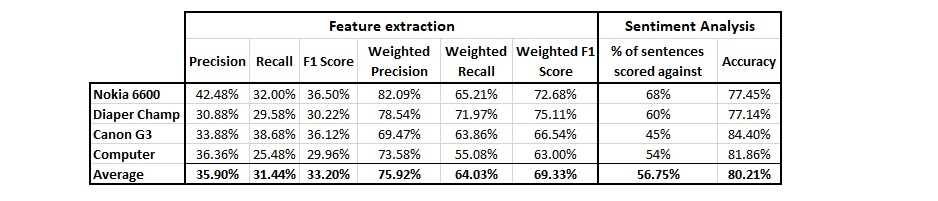

From a qualitative point of view multi word features were picked up well, for example “LCD screen”, “Photo quality” and battery life for the Canon camera. The summary reads well, and most of the sentences make sense in context. There are many where a feature is mentioned, but not the focal point of the sentence, however. A more syntactic based approach would help improve this.

#### References
Agarwal, R. and Srikant, R., 1994, September. Fast algorithms for mining association rules. In Proc. of the 20th VLDB Conference (Vol. 487, p. 499).

Bird S., Loper E., and Klein E., 2009. Natural Language Processing with Python. O'Reilly Media Inc.

Crystal, D., 1980. A First Dictionary of Linguistics and Phonetics. Boulder, CO: Westview.

Dhaoui, C., Webster, C.M. and Tan, L.P., 2017. Social media sentiment analysis: lexicon versus machine learning. Journal of Consumer Marketing, 34(6), pp.480-488.

Hamilton, W.L., Clark, K., Leskovec, J. and Jurafsky, D., 2016, November. Inducing domain-specific sentiment lexicons from unlabeled corpora. In Proceedings of the conference on empirical methods in natural language processing. conference on empirical methods in natural language processing (Vol. 2016, p. 595). NIH Public Access.

Hu, M. and Liu, B., 2004, August. Mining and summarizing customer reviews. In Proceedings of the tenth ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 168-177).

Hu, M. and Liu, B., 2004, July. Mining opinion features in customer reviews. In AAAI (Vol. 4, No. 4, pp. 755-760).

Jurafsky, D. and Martin, J.H., 2020. Speech and Language Processing (Draft). 2017. Available from: https://web.stanford.edu/~jurafsky/slp3 [Accessed 22nd April 2023]

Kalyanathaya, K.P., Akila, D. and Suseendren, G., 2019. A fuzzy approach to approximate string matching for text retrieval in NLP. J. Comput. Inf. Syst. USA, 15(3), pp.26-32.

Kim, H., Howland, P., Park, H. and Christianini, N., 2005. Dimension reduction in text classification with support vector machines. Journal of machine learning research, 6(1).

Lal, U,. 2022. Increasing Accuracy of Sentiment Classification Using Negation Handling. Available from: https://towardsdatascience.com/increasing-accuracy-of-sentiment-classification-using-negation-handling-9ed6dca91f53 [Accessed 22nd April 2023]

Liu, Q., Gao, Z., Liu, B. and Zhang, Y., 2015, June. Automated rule selection for aspect extraction in opinion mining. In Twenty-Fourth international joint conference on artificial intelligence.

Nasim, Z., Rajput, Q. and Haider, S., 2017, July. Sentiment analysis of student feedback using machine learning and lexicon based approaches. In 2017 international conference on research and innovation in information systems (ICRIIS) (pp. 1-6). IEEE.

Marcus M., Santorini B., Marcinkiewicz M A., 1993. Building a Large Annotated Corpus of English: The Penn Treebank. Computational Linguistics, 19:313-330.

Paul, D.B. and Baker, J., 1992. The design for the Wall Street Journal-based CSR corpus. In Speech and Natural Language: Proceedings of a Workshop Held at Harriman, New York, February 23-26, 1992.

Qiu, G., Liu, B., Bu, J. and Chen, C., 2011. Opinion word expansion and target extraction through double propagation. Computational linguistics, 37(1), pp.9-27.

Saurí, R., 2008. A factuality profiler for eventualities in text. Brandeis University.

Stehman, Stephen V. 1997. "Selecting and interpreting measures of thematic classification  accuracy". Remote Sensing of Environment. 62 (1): 77–89.

Palanisamy, P., Yadav, V. and Elchuri, H., 2013, June. Serendio: Simple and Practical lexicon based approach to Sentiment Analysis. In Second Joint Conference on Lexical and Computational Semantics (* SEM), Volume 2: Proceedings of the Seventh International Workshop on Semantic Evaluation (SemEval 2013) (pp. 543-548).

Pang, B., Lee, L. and Vaithyanathan, S., 2002. Thumbs up? Sentiment classification using machine learning techniques.

Taboada, M., Brooke, J., Tofiloski, M., Voll, K. and Stede, M., 2011. Lexicon-based methods for sentiment analysis. Computational linguistics, 37(2), pp.267-307.

Ullman, J., 2011. Mining of massive datasets. Cambridge University Press.

Webster, J.J. and Kit, C., 1992. Tokenization as the initial phase in NLP. In COLING 1992 volume 4: The 14th international conference on computational linguistics.

Wei, C.P., Chen, Y.M., Yang, C.S. and Yang, C.C., 2010. Understanding what concerns consumers: a semantic approach to product feature extraction from consumer reviews. Information Systems and E-Business Management, 8, pp.149-167.

Wiegand, M., Balahur, A., Roth, B., Klakow, D. and Montoyo, A., 2010, July. A survey on the role of negation in sentiment analysis. In Proceedings of the workshop on negation and speculation in natural language processing (pp. 60-68).

Zahoor, K., Bawany, N.Z. and Hamid, S., 2020, November. Sentiment analysis and classification of restaurant reviews using machine learning. In 2020 21st International Arab Conference on Information Technology (ACIT) (pp. 1-6). IEEE.

W. S. Noble,. 2006. "What is a support vector machine?" Nature Biotechnology, vol. 24, no. 12, pp. 1565-1567.